In [4]:
# грузанем нужную штуку
!pip install docx2txt

  Created wheel for docx2txt: filename=docx2txt-0.8-cp37-none-any.whl size=3963 sha256=9bda1be04fe76258d3ee4f27383f7523a2a9bedadb6ce525db13346058db4d91
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt


In [5]:
import gc
import pickle
import bz2
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import docx2txt
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# для работы в колабе
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# useful shit

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


def read_df(filepath, columns, usecols=None):
    """
    Read dataframe from given filepath
    """
    if usecols is None:
        usecols = columns
    df = pd.read_csv(
        filepath_or_buffer=one,
        header=0,
        sep=';',
        names=columns,
        usecols=usecols,
        parse_dates=['date'],
        date_parser=dateparse
    )
    return df


def read_docx(filepath, columns, sep=';'):
    """
    Read docx to pd.DataFrame
    """
    text = docx2txt.process(filepath)
    dick = [x.strip() for x in text.split('\n') if x != '']
    dick.pop(0) # remove column names

    json_dick = {}
    for col in columns:
        json_dick[col] = []
    for x in dick:
        y = x.split(sep)
        for col, val in zip(columns, y):
            json_dick[col].append(val)

    return pd.DataFrame(json_dick)


def read_pickled(filepath):
    """
    Read pickled dataframes
    """
    with bz2.open(filepath, 'rb') as f:
        return pickle.load(f)

In [10]:
# грузанем категории товаров
cols = [s for s in 'id_tov;id_group;name_group'.split(';')]
products_cat = read_docx('product_groups.docx', columns=cols)
products_cat['id_tov'] = products_cat.id_tov.astype(int)
products_cat['id_group'] = products_cat.id_group.astype(int)
print(products_cat.head())
print(products_cat.dtypes)

   id_tov  id_group              name_group
0      52     10004  Кисломолочные продукты
1      75     10004  Кисломолочные продукты
2      77     10004  Кисломолочные продукты
3     143     10004  Кисломолочные продукты
4     151     10004  Кисломолочные продукты
id_tov         int64
id_group       int64
name_group    object
dtype: object


In [11]:
get_date = lambda s: s.dt.date


def read_data(filepath, extract_day=True):
    df = read_pickled(filepath)
    df.drop(columns=['id_doc', 'id_card', 'is_green'], inplace=True)
    if extract_day:
        df['day'] = get_date(df.date)
    return df

In [12]:
# анализ только по сентябрю, со всеми месяцами чет тяжко для RAM
df_one = read_data('gdrive/MyDrive/09_prepared.pkl.bz2')

In [6]:
# 0 - оффлайн, 1 - онлайн
df_one.loc[df_one['id_order'] != 0, 'id_order'] = 1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 864x576 with 0 Axes>

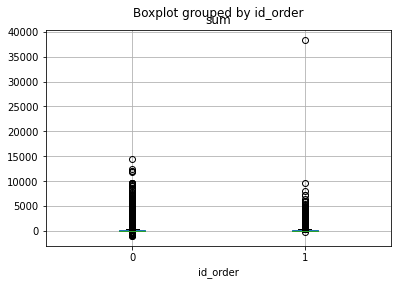

In [7]:
# в онлайне вон есть мощная закупка по одному товару, и еще есть отрицательные суммы
plt.figure(figsize=(12, 8))
df_one.boxplot(by='id_order', column='sum');

In [8]:
# количество товаров в чеках
df_one.groupby('id_doc_int').size().sort_values(ascending=False).head(10)

id_doc_int
2937461     174
13543180    110
4359470     108
9968657     108
1484069     100
23113636    100
3649983      99
1785713      97
8404161      96
12655489     96
dtype: int64

In [9]:
# количество товаров в чеках с другого конца
df_one.groupby('id_doc_int').size().sort_values().head()

id_doc_int
8735588     1
6561184     1
6561191     1
6561192     1
21834708    1
dtype: int64

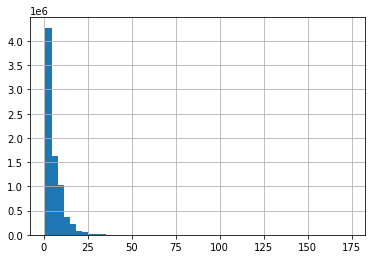

In [10]:
df_one.groupby('id_doc_int').size().hist(bins=50)

In [11]:
# щас бы закупаться икрой на 38400
df_one[df_one['sum'] == df_one['sum'].max()]

,date,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int,day
38060134,2020-09-28 08:36:51,1,21379,18018,16.0,38400.0,1755035,14218897,2020-09-28


In [12]:
# цена икры
38400.0 / 16

2400.0

In [13]:
# чет икра дорогая
products_cat[products_cat['id_tov'] == 21379]

,id_tov,id_group,name_group
1546,21379,10053,Икра


In [14]:
df_one[df_one['id_card_int'] == 1755035]['id_tov'].unique()

array([21379,   647])

In [15]:
# ну икру в чем-то надо нести, чел берет чисто икры на 38400 и пакеты, ну явно необычный
products_cat[products_cat['id_tov'] == 647]

,id_tov,id_group,name_group
3450,647,10155,Упаковка


In [16]:
card_doc_grouped = df_one.groupby(['id_card_int', 'id_doc_int'])['sum'].sum().reset_index()
card_doc_grouped = card_doc_grouped.groupby('id_card_int')['sum'].max()

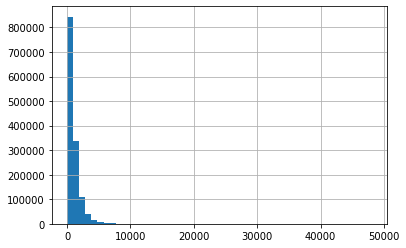

In [17]:
# распределение максимальных чеков по картам
card_doc_grouped.hist(bins=50);

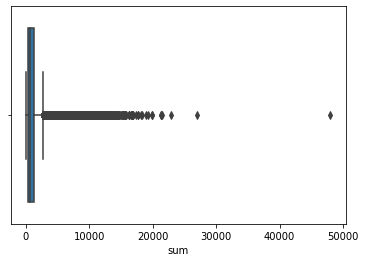

In [18]:
# распределение максимальных чеков по картам, ток теперь боксплотом
sns.boxplot(x=card_doc_grouped);

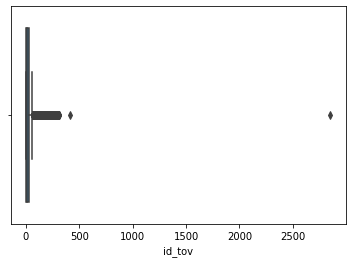

In [19]:
# количество различных товаров для каждой из карт
sns.boxplot(x=df_one.groupby('id_card_int')['id_tov'].nunique());

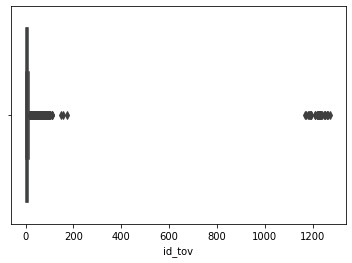

In [20]:
# количество различных товаров для каждой из карт по дням
sns.boxplot(x=df_one.groupby(['id_card_int', 'day'])['id_tov'].nunique());

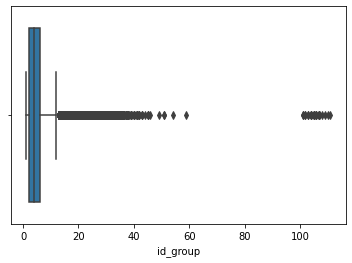

In [22]:
# количество различных категорий товаров для каждой из карт по дням
sns.boxplot(x=df_one.merge(products_cat[['id_tov', 'id_group']], on='id_tov').groupby(['id_card_int', 'day'])['id_group'].nunique());

In [15]:
# уберем тех, кто брал много разных категорий товаров в один день
tov_groups = df_one.merge(products_cat[['id_tov', 'id_group']], on='id_tov').groupby(['id_card_int', 'day'])['id_group'].nunique().reset_index()
bad_guys = tov_groups[tov_groups.id_group >= 100]['id_card_int'].unique()

In [21]:
# добавим любителя икры
bad_guys = np.concatenate([bad_guys, [1755035]])

In [25]:
bad_guys = bad_guys.tolist()

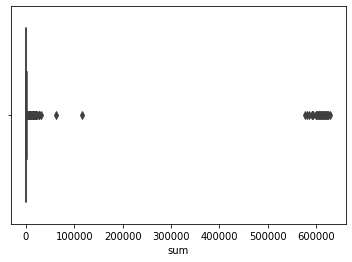

In [28]:
sns.boxplot(x=df_one.groupby(['id_card_int', 'day'])['sum'].sum());

In [29]:
dayly_sums = df_one.groupby(['id_card_int', 'day'])['sum'].sum().reset_index()
dayly_sums[dayly_sums['sum'] >= 100000]['id_card_int'].unique()

array([ 883386, 1755035])

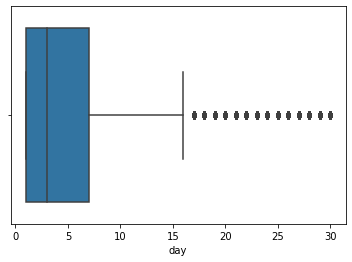

In [31]:
# найдем карты, по которым наиболее часто проводятся покупки
sns.boxplot(x=df_one.groupby(['id_card_int'])['day'].nunique());

In [33]:
days = df_one.groupby(['id_card_int'])['day'].nunique().reset_index()

12              14
17              19
29              36
35              42
44              51
            ...   
1353925    1927066
1354284    1927639
1354845    1928357
1355455    1929135
1358087    1941912
Name: id_card_int, Length: 65928, dtype: int64

In [39]:
bad_guys += days[days['day'] >= 17]['id_card_int'].values.tolist()
bad_guys = list(set(bad_guys))
print(len(bad_guys))
print(883386 in bad_guys)
print(1755035 in bad_guys)

65929
True
True


In [46]:
with bz2.open('bad_guys.bz2.pickle', 'wb') as f:
    pickle.dump(pd.DataFrame({'id_card_int': bad_guys}), f, protocol=4)

In [48]:
with bz2.open('bad_guys.bz2.pickle', 'rb') as f:
    res = pickle.load(f)